# Parameter Estimation from ∆∆F

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [2]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.bayes
import mut.viz
import pystan
colors = mut.viz.personal_style()
constants = mut.thermo.load_constants()

# Load the data. 
data = pd.read_csv('../../data/csv/compiled_data.csv')

# Load the Stan magic function for inference. 
%load_ext stanmagic

In this notebook, we try to use the empirically calculated difference in the free energy of binding as a target for parameter estimation. Here, we consider all of the single mutants (DNA binding domain and inducer binding domain) and test if different combinations of parameters can capture the phenomenology of the induction profiles. 

As we have derived, the difference between the empirically determined change in binding free energy relative to an arbitrarily chosen reference state can be calculated as

$$
\Delta F^* - \Delta F = k_BT \left[ \log{p_{act}(c) \over p_{act}^*(c)} - {\Delta\varepsilon_{RA}^* - \Delta\varepsilon_{RA}\over k_BT} \right] \tag{1}, 
$$

where $\Delta F^*$ is the empirically determined change in free energy of binding and $\Delta F$ is the difference in free energy of binding of the wild-type repressor relative to the reference state. 

I think there are characteristic profiles of deviation from the reference strain depending on which parameters change. Here, we examine this from a data based approach.

The choice of the reference state (as of this writing) is arbitrary, although I think we can get at this in a more meaningful manner. For simplicity, we can consider the reference state to have a DNA binding energy of $-13.9\, k_BT$ (that of the O2 operator), $R = 260$ (an arbitrary choice for historical reasons), and an inducer concentration of $c = 50\mu$M (approximately the [$EC_{50}$] for this strain). Below, we define these states and examine the range of the $\Delta F$ imposed by this choice of reference state. 

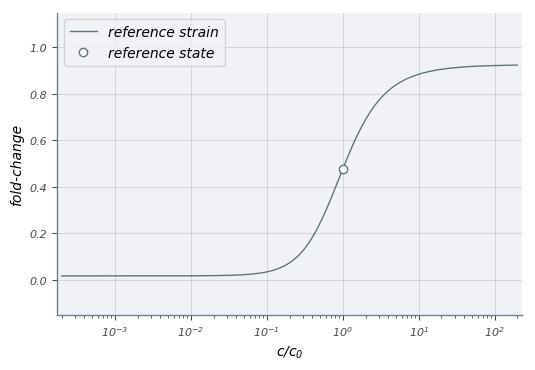

In [3]:
# Define the reference parameters. 
R0 = constants['RBS1027'] 
c0 = 50 # in µM
epRA = constants['O2']
ref_state = mut.thermo.SimpleRepression(R=R0, effector_conc=c0, 
                                       ep_r=epRA, ka=constants['Ka'],
                                       ki=constants['Ki'], ep_ai=constants['ep_AI'],
                                       n_sites=constants['n_sites'])

# Define the reference strain (i.e. wild-typel)
c_range = np.logspace(-2, 4, 200) # in µM
ref_strain = mut.thermo.SimpleRepression(R=R0, effector_conc=c_range, 
                                       ep_r=epRA, ka=constants['Ka'],
                                       ki=constants['Ki'], ep_ai=constants['ep_AI'],
                                       n_sites=constants['n_sites'])

# Instantiate the figure
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.set_xscale('log')
ax.set_xlabel('$c / c_0$', fontsize=10)
ax.set_ylabel('fold-change', fontsize=10)
ax.set_ylim([-0.15, 1.15])

# Plot the reference strain and state. 
ax.plot(c_range / c0, ref_strain.fold_change(), '-', lw=1, color=colors[0], 
           label='reference strain')
ax.plot(c0 / c0, ref_state.fold_change(), 'o', markerfacecolor='w', color=colors[0], 
           label='reference state')
ax.legend(fontsize=10)

## Part I: DNA Binding Domain Mutation

Given a mutation in the DNA binding domain, what biophysical parameters are changed? Is it *only* the DNA binding energy, or do other biophysical parameters change in response? Here, we have three differen mutations in the DNA binding domain (Y20I, Q21A, and Q21M) which alter *at least* the affinity of the repressor to the DNA.  

To begin, we can examine induction profiles relative to the reference state and strain shown above

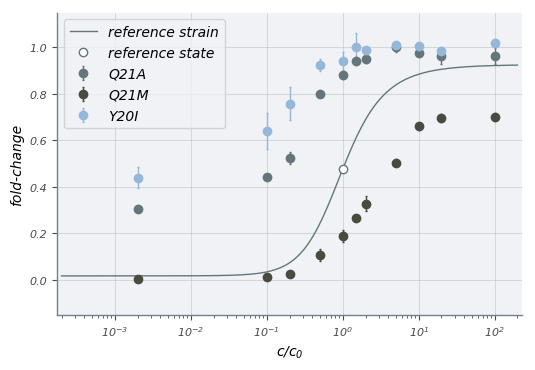

In [4]:
# Isolate the data to DNA binding mutations
DNA = data[(data['class']=='DNA') & (data['operator']=='O2') &
          (data['repressors']==260)].copy()

# Group them by IPTG and compute the aggregate props. 
grouped = DNA.groupby(['mutant', 'IPTGuM']).agg(('mean', 'sem')).reset_index()

# Instantiate the figure
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.set_xscale('log')
ax.set_xlabel('$c / c_0$', fontsize=10)
ax.set_ylabel('fold-change', fontsize=10)
ax.set_ylim([-0.15, 1.15])

# Plot the reference strain and state. 
ax.plot(c_range / c0, ref_strain.fold_change(), lw=1, color=colors[0], 
           label='reference strain')
ax.plot(c0 / c0, ref_state.fold_change(), 'o', markerfacecolor='w', color=colors[0], 
           label='reference state')
for g, d in grouped.groupby('mutant'):
    ax.errorbar(d['IPTGuM']/c0, d['fold_change']['mean'], d['fold_change']['sem'],
               fmt='o', linestyle='none', lw=1, capsize=1, label=g)
ax.legend(fontsize=10)

These mutants are distinctly different than the reference strain. However, it is not possible to identify which parameters are changing just from looking at the curves relative to the reference strain. However, if the difference is *only* in the DNA binding energy $\Delta\varepsilon_{RA}$, the difference in the free energy of binding should be constant and independent of inducer concentration. The empirical $\Delta F$ can be directly calcuated from the fold-change measurements,

$$
\Delta F^* = F_0 - \log\left({1 \over \text{fold-change}} - 1\right),
$$

This immediately reveals an issue $--$ while theoretically the fold-change is restricted to $[0, 1]$ experimental measurements can go beyond these bounds thanks to mesurement error. Therefore, it is not possible to compute $\Delta F^*$ without neglecting some of the data. Nevertheless, we can continue along our merry way and see how it all works out. 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


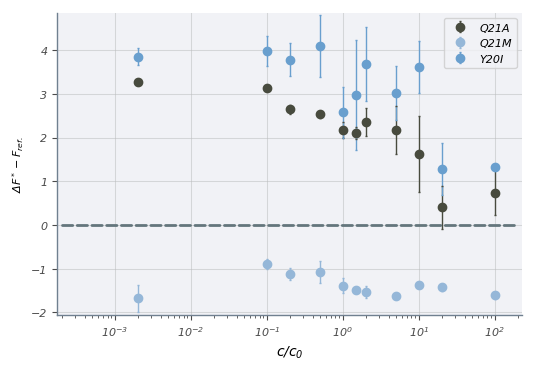

In [5]:
# Compute the reference state at the same inducer concentrations. 
_ref_strain = mut.thermo.SimpleRepression(R=260, ep_r=constants['O2'],
                                        effector_conc=DNA['IPTGuM'],
                                        ep_ai=constants['ep_AI'],
                                        ka=constants['Ka'], ki=constants['Ki'], 
                                        n_sites=constants['n_sites'])

# Compute the empirical delta F from the experimental measurements. 
DNA['empirical_F'] = -ref_state.bohr_parameter() - np.log((1 / DNA['fold_change']) - 1)

# Compute the change in the free energy of binding. 
DNA['empirical_ddf'] = DNA['empirical_F'] - (-ref_state.bohr_parameter() + _ref_strain.bohr_parameter())

# Group by the inducer concentration and mutant, and compute the mean + sem.
grouped = DNA.groupby(['mutant', 'IPTGuM'])['empirical_ddf'].agg(('mean', 'sem')).reset_index()

# Instantiate the figure. 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.set_xlabel('$c / c_0$', fontsize=10)
ax.set_ylabel('$\Delta F^* - F_\mathrm{ref.}$')
ax.set_xscale('log')

# Plot the zero 
ax.plot(np.array([1E-2, 1E4]) / c0, [0, 0], '--', label='__nolegend__')

# iterate through the computed ddf and plot. 
for g, d in grouped.groupby(['mutant']):
    ax.errorbar(d['IPTGuM'] / c0, d['mean'], d['sem'], lw=1, capsize=1, label=g,
               linestyle='none', fmt='o')
ax.legend()

Q21M appears to be constant (within noise, at least), but Q21A and Y20I show some dependence on concentration. HOwever, I'm not convinced that's actually the case. By calculating the empirical ∆F *directly* from data, we are tossing data that is above 1 or below zero. Thus, we are really only computing the average of tail of the true distribution. It's a little more instructive to look at all of the data rather than simply the means and standard errors.

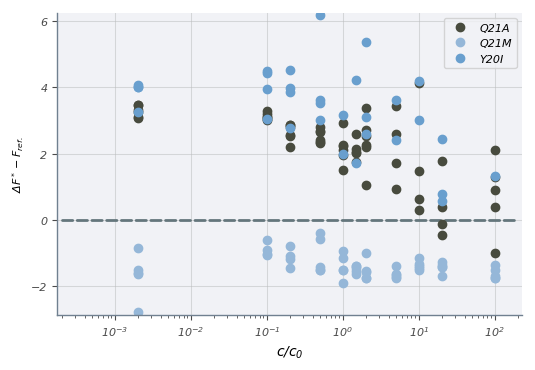

In [7]:
# Instantiate the figure. 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.set_xlabel('$c / c_0$', fontsize=10)
# ax.set_ylabel('$\Delta F^* - F_\mathrm{ref.}$')
ax.set_xscale('log')

# Plot the zero 
# ax.plot(np.array([1E-2, 1E4]) / c0, [0, 0], '--', label='__nolegend__')

# iterate through the computed ddf and plot. 
for g, d in DNA.groupby(['mutant']):
    ax.plot(d['', d['empirical_ddf'], lw=1, label=g, marker='o',
               linestyle='none')
ax.legend()

In [8]:
d

,date,username,mutant,operator,IPTGuM,repressors,fold_change,class,empirical_F,empirical_ddf
75,20180131,sbarnes,Y20I,O2,0.0,260.0,0.504564,DNA,0.118883,4.126324
77,20180131,sbarnes,Y20I,O2,0.1,260.0,0.302482,DNA,-0.734878,3.268058
83,20180131,sbarnes,Y20I,O2,5.0,260.0,0.418293,DNA,-0.229160,3.034672
87,20180131,sbarnes,Y20I,O2,10.0,260.0,0.553278,DNA,0.314549,2.761042
93,20180131,sbarnes,Y20I,O2,25.0,260.0,0.867498,DNA,1.979644,3.026855
99,20180131,sbarnes,Y20I,O2,50.0,260.0,0.869551,DNA,1.997625,1.997625
104,20180131,sbarnes,Y20I,O2,75.0,260.0,0.897530,DNA,2.270700,1.722925
110,20180131,sbarnes,Y20I,O2,100.0,260.0,0.997879,DNA,6.254415,5.358845
113,20180131,sbarnes,Y20I,O2,250.0,260.0,0.982867,DNA,4.150089,2.406724
121,20180131,sbarnes,Y20I,O2,500.0,260.0,0.993651,DNA,5.153691,3.019818
